In [3]:
import os
import numpy as np
import torch
import util
import matplotlib.pyplot as plt
from data import fr
from torch.autograd.gradcheck import zero_gradients
%matplotlib inline
from utils_project import compute_jacobian_and_bias,compute_bias, check_bias

In [4]:
fr_path = 'checkpoint/model_snr_30_bias_no/fr/epoch_300.pth'
fc_path = 'checkpoint/model_snr_30_bias_no/fc/epoch_300.pth'
data_dir = 'test_dataset'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#load models
fr_module, _, _, _, _ = util.load(fr_path, 'fr', device)
fr_module.cpu()
fr_module.eval()
xgrid = np.linspace(-0.5, 0.5, fr_module.fr_size, endpoint=False)

In [5]:
#load data
f = np.load(os.path.join(data_dir, 'f.npy'))
signal_0dB = np.load(os.path.join(data_dir, '0.0dB.npy'))
signal_10dB = np.load(os.path.join(data_dir, '10.0dB.npy'))
signal_50dB = np.load(os.path.join(data_dir, '50.0dB.npy'))
nfreq = nfreq = np.sum(f >= -0.5, axis=1)
idx = 8
inp = torch.as_tensor(signal_10dB[idx][None])

In [4]:
jacobian, inputs, outputs = compute_jacobian_and_bias(inp, fr_module)
bias = compute_bias(jacobian, inputs, outputs)

In [5]:
fft_filter = jacobian[0] + 1j * jacobian[1]
bias = bias.reshape(-1)

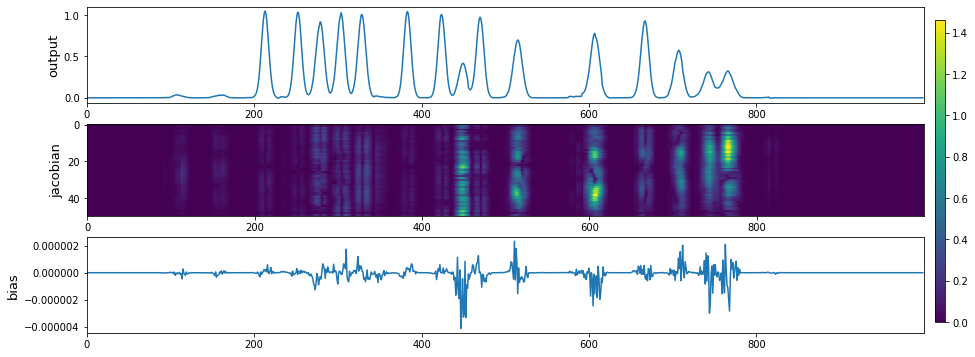

In [6]:
fig, ax = plt.subplots(3, 1, figsize=(15, 6))

ax[0].plot(xgrid, outputs[0])
ax[0].set_xticks(np.arange(-0.5, 0.5, 0.2))
ax[0].set_xticklabels(np.arange(0, 1000, 200))
ax[0].set_xlim(-0.5, 0.5)
ax[0].set_ylabel('output', fontsize=13)

im = ax[1].imshow(np.abs(fft_filter))
ax[1].set_aspect(2.2)
ax[1].set_ylabel('jacobian', fontsize=13)

ax[2].plot(xgrid, bias)
ax[2].set_xticks(np.arange(-0.5, 0.5, 0.2))
ax[2].set_xticklabels(np.arange(0, 1000, 200))
ax[2].set_xlim(-0.5, 0.5)
ax[2].set_ylabel('bias', fontsize=13)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [11]:
from data.data import gen_signal
# three outputs from this function: signal [num_samples, 2, signal_dim]; frequency (float)[num_samples, num_freq];
# num_freq:int [num_samples] 
from data.noise import noise_torch

# hyper parameter setting
num_samples=10
signal_dim=50
num_freq=1
min_sep=1.
snr=10
fixed_freq = 0.4 # set None for  random frequency

In [12]:
clean_signals, signal_frs, signal_num_freqs = gen_signal(num_samples=num_samples, 
                                                         signal_dim=signal_dim, 
                                                         num_freq=num_freq, min_sep=min_sep,
                                                        fixed_freq=fixed_freq)
noisy_signals = noise_torch(torch.as_tensor(clean_signals), snr, 'gaussian')
idx = 0
clean_signal, signal_fr, signal_num_freq = clean_signals[idx], signal_frs[idx], signal_num_freqs[idx]
noisy_signal = noisy_signals[idx].cpu().numpy()
print(clean_signal.shape)
clean_signal_t = clean_signal[0] + clean_signal[1] * 1j 
clean_signal_fft = np.fft.fft(clean_signal_t, n=1000)
clean_signal_fft = np.fft.fftshift(clean_signal_fft)
noisy_signal_t = noisy_signal[0] + 1j * noisy_signal[1]
noisy_signal_fft = np.fft.fft(noisy_signal_t, n=1000)
noisy_signal_fft = np.fft.fftshift(noisy_signal_fft)

(array([inf]), 1, 0.02, 'fixed', 0.4)
(array([inf]), 1, 0.02, 'fixed', 0.4)
(array([inf]), 1, 0.02, 'fixed', 0.4)
(array([inf]), 1, 0.02, 'fixed', 0.4)
(array([inf]), 1, 0.02, 'fixed', 0.4)
(array([inf]), 1, 0.02, 'fixed', 0.4)
(array([inf]), 1, 0.02, 'fixed', 0.4)
(array([inf]), 1, 0.02, 'fixed', 0.4)
(array([inf]), 1, 0.02, 'fixed', 0.4)
(array([inf]), 1, 0.02, 'fixed', 0.4)
(2, 50)


In [13]:
signal_fr[0]

0.4

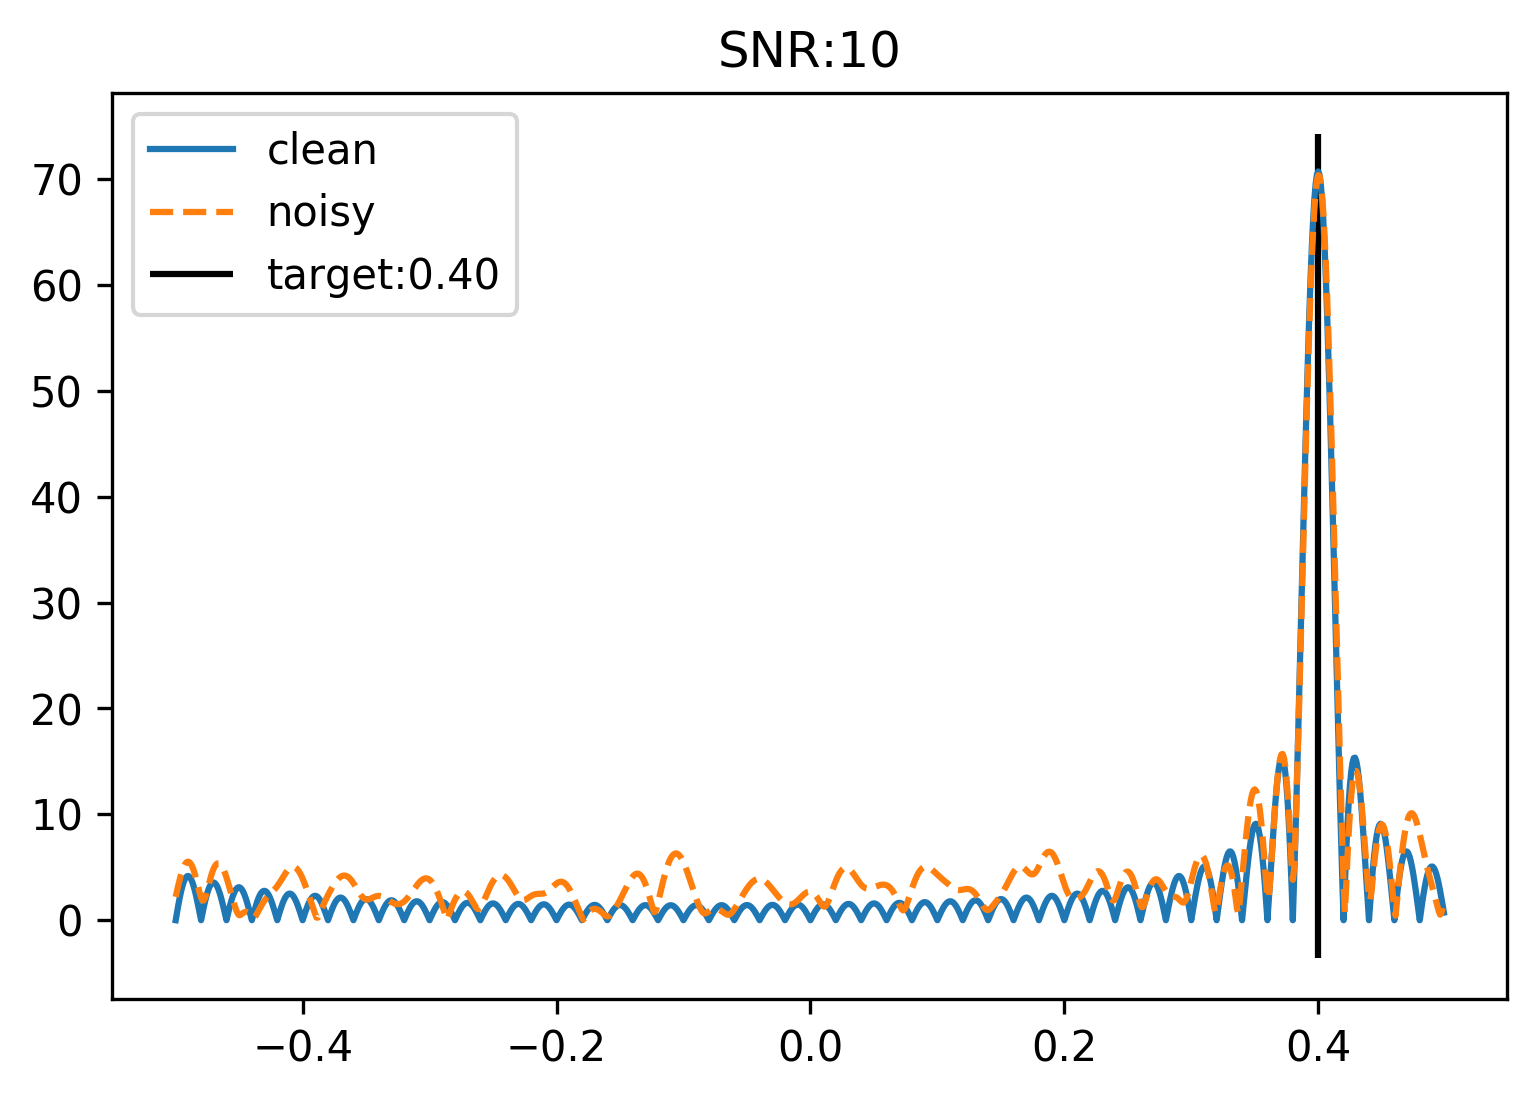

In [14]:
fig, ax = plt.subplots(dpi=300)
xgrid = np.linspace(-0.5, 0.5, fr_module.fr_size, endpoint=False)
ax.plot(xgrid, np.abs(clean_signal_fft),label='clean')
ax.plot(xgrid, np.abs(noisy_signal_fft),'--', label='noisy')
ylim = ax.get_ylim()
ax.vlines(signal_fr[0],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[0]))
ax.set_title('SNR:{}'.format(snr))
ax.legend()

In [15]:
noisy_signal = torch.as_tensor(noisy_signal).unsqueeze(dim=0)
jacobian, inputs, outputs = compute_jacobian_and_bias(noisy_signal, fr_module)
fft_filter = jacobian[0] - 1j * jacobian[1]

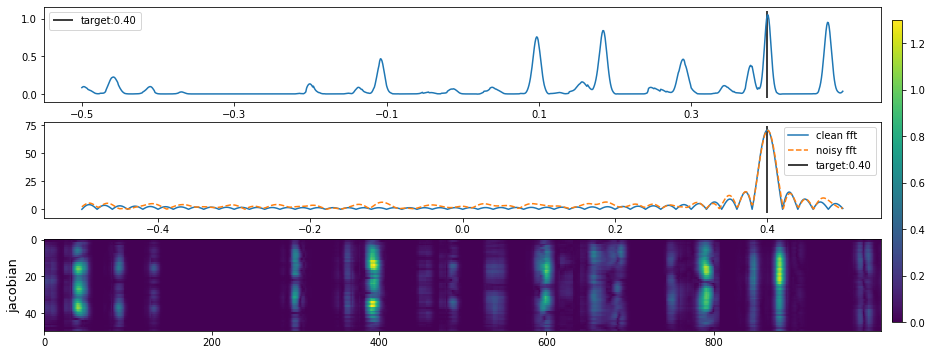

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(15, 6))

ax[0].plot(xgrid, outputs[0])
ax[0].set_xticks(np.arange(-0.5, 0.5, 0.2))
ylim = ax[0].get_ylim()
ax[0].vlines(signal_fr[0],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[0]))
ax[0].legend()

ax[1].plot(xgrid, np.abs(clean_signal_fft),label='clean fft')
ax[1].plot(xgrid, np.abs(noisy_signal_fft),'--', label='noisy fft')
ylim = ax[1].get_ylim()
ax[1].vlines(signal_fr[0],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[0]))
ax[1].legend()
im = ax[2].imshow(np.abs(fft_filter))
ax[2].set_aspect(2.2)
ax[2].set_ylabel('jacobian', fontsize=13)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [ ]:
noisy_signal_t